In [1]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
#import xml.etree.ElementTree as ET
import imutils
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.datasets as dset
from torch.optim import lr_scheduler

## 0. test on GPU/ CUDA/ PyTorch

In [2]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [3]:
device

device(type='cuda', index=0)

# 1. Data loading and visualized helper functions

### 1.1 my self defined helper function and loader

In [4]:
def picshow(img,title="pics"):
    num = len(img)
    ax = np.ceil(np.sqrt(num)) 
    ay = np.rint(np.sqrt(num)) 
    fig =plt.figure()
    plt.title(title)
    plt.axis("off")
    for i in range(1,num+1):
        sub = fig.add_subplot(ax,ay,i)
        #sub.set_title("titre",i)
        sub.axis('off')
        sub.imshow(cv2.cvtColor(img[i-1].transpose(1, 2, 0),
                                              cv2.COLOR_BGR2RGB))
                                #cv2.normalize(, None, alpha=0.0, beta=1.0, 
                                #norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        #.astype(np.uint8)
    plt.show()

In [6]:
def imgloader(filepath):
    filelist = glob.glob(folderpath+'/*.png')
    filelist=[filelist[i] for i in file_list]
    DataP= np.array([cv2.resize(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, 
                                   norm_type=cv2.NORM_MINMAX,
                                       dtype=cv2.CV_32F),(320,240)).transpose((2, 0, 1))
                     for fname in filelist ])
    return torch.from_numpy(DataP).to(device) 

In [59]:
#torch.cat

### 1.2 PyTorch default suite tool loader 

In [60]:
dataset = dset.ImageFolder(root="BasicData",
                           transform=transforms.Compose([
                               transforms.Grayscale(1),
                               transforms.Resize((240,320)),
                               transforms.ToTensor(),
                               transforms.Normalize(( 0.5), ( 0.5)), # only one 0.5 as gray
                           ]))
#
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True, num_workers=0)

# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset, = torch.utils.data.random_split(dataset,[len_train_set, len_valid_set ])
# shuffle and batch the datasets
# num_workers was 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=5, shuffle=True, num_workers=0)

The length of Train set is 1620
The length of Valid set is 180


### 1.3  PyTorch's customized loader for data augmentation like adding noise  

# 2. CNN Models

### 2.1 my self defined vannila network

In [43]:
nc = 8
class BinaryClass(nn.Module):
    def __init__(self,ngpu):
        super(BinaryClass, self).__init__() # referring to the inherit class as nn.Module explicitly
        self.ngpu = ngpu
        self.main=nn.Sequential(
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, 
        #groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)    
        #input is  1, 240, 320
        nn.Conv2d(1 , nc, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nc), 
        nn.LeakyReLU(0.2, inplace=True),
        # 120 x 160
        nn.Conv2d(nc , nc*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nc*2), 
        nn.LeakyReLU(0.2, inplace=True),
        # 60 x 80
        nn.Conv2d(nc*2 , nc*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nc*2), 
        nn.LeakyReLU(0.2, inplace=True),
        # 30 x 40
        nn.Conv2d(nc*2 , nc, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nc), 
        nn.LeakyReLU(0.2, inplace=True),
        # 15 x 20
        nn.Flatten(),
        nn.Linear(300*nc,2)
        )
    def forward(self,x):
        return self.main(x)
        

In [44]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [45]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

netD = BinaryClass(ngpu).to(device)
#network.to(cuda) == network.cuda()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999),weight_decay=0.0) #


BinaryClass(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): 

In [22]:
test0=torch.ones(2,1,240,320).to(device) 

In [47]:
result = netD(test0)

In [48]:
result.shape

torch.Size([2, 2])

In [50]:
result.cpu()[0]

tensor([0.6815, 0.0422], grad_fn=<SelectBackward0>)

training

In [29]:
loss_min = np.inf
num_epochs = 10

In [ ]:
start_time = time.time()
for epoch in range(1,num_epochs+1):

    loss_train = 0
    loss_valid = 0
    running_loss = 0
    netD.train()
    for step in range(1,len(train_loader)+1):

        images, labels = next(iter(train_loader))

        images = images.cuda()
        labels = labels.view(labels.size(0),-1).cuda() 

        predictions = netD(images)

        # clear all the gradients before calculating them
        optimizerD.zero_grad()

        # find the loss for the current step
        loss_train_step = criterion(predictions, labels)

        # calculate the gradients
        loss_train_step.backward()

        # update the parameters
        optimizer.step()

        loss_train += loss_train_step.item()
        running_loss = loss_train/step

        #print_overwrite(step, len(train_loader), running_loss, 'train')
        
    netD.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, labels = next(iter(valid_loader))
        
            images = images.cuda()
            labels = labels.view(labels.size(0),-1).cuda()
        
            predictions = netD(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, labels)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            #print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(netD.state_dict(), 'face_labelsLower.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
    

### 2.2 resnet18

In [83]:

model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion2 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [88]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                #best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    #model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'resnet18.pth') 
    return model

In [77]:
dataloaders = {'train': train_loader, 'val' : valid_loader 
              }

dataset_sizes = {'train': len_train_set, 'val' : len_valid_set   } 


In [89]:
model_ft = train_model(model_ft, criterion2, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1892 Acc: 0.9364
val Loss: 0.3474 Acc: 0.8611

Epoch 1/24
----------
train Loss: 0.1503 Acc: 0.9500
val Loss: 1.4000 Acc: 0.5833

Epoch 2/24
----------
train Loss: 0.1390 Acc: 0.9586
val Loss: 0.1091 Acc: 0.9778

Epoch 3/24
----------
train Loss: 0.1462 Acc: 0.9549
val Loss: 0.2094 Acc: 0.9222

Epoch 4/24
----------
train Loss: 0.1070 Acc: 0.9667
val Loss: 0.1600 Acc: 0.9556

Epoch 5/24
----------
train Loss: 0.0828 Acc: 0.9759
val Loss: 0.1057 Acc: 0.9778

Epoch 6/24
----------
train Loss: 0.0876 Acc: 0.9759
val Loss: 0.1083 Acc: 0.9778

Epoch 7/24
----------
train Loss: 0.0780 Acc: 0.9821
val Loss: 0.1058 Acc: 0.9778

Epoch 8/24
----------
train Loss: 0.0643 Acc: 0.9790
val Loss: 0.1053 Acc: 0.9778

Epoch 9/24
----------
train Loss: 0.0687 Acc: 0.9772
val Loss: 0.1064 Acc: 0.9778

Epoch 10/24
----------
train Loss: 0.0673 Acc: 0.9802
val Loss: 0.1067 Acc: 0.9778

Epoch 11/24
----------
train Loss: 0.0765 Acc: 0.9722
val Loss: 0.1133 Acc: 0.9778

Ep

In [93]:
class_names = dataset.classes

In [95]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [96]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

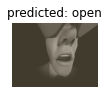

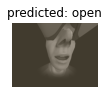

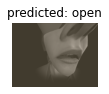

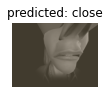

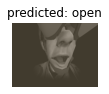

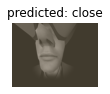

In [97]:
visualize_model(model_ft)

In [100]:
those = cv2.imread("yeah.png")


In [101]:
these = TF.normalize(TF.to_tensor((cv2.cvtColor(those, cv2.COLOR_BGR2GRAY))), [0.5], [0.5]).unsqueeze(0)

In [104]:
with torch.no_grad(): #To perform inference without Gradient Calculation.
        outputs = model_ft(these.cuda())
        _, preds = torch.max(outputs, 1)


In [105]:
preds.shape

torch.Size([1])

In [122]:
class_names[preds[0]]

'close'

In [ ]:
plt.figure()
plt.subplot()
plt.title=class_names[preds[0]]
plt.imshow(those)
plt.axis("off")
print(class_names[preds[0]])

In [136]:
those.shape

(224, 224, 3)

In [146]:
def OneStopPred(those,model = model_ft): #(FilePath,model = model_ft):
    #those = cv2.imread(FilePath)
    these = TF.normalize(TF.to_tensor((cv2.cvtColor(those, cv2.COLOR_BGR2GRAY))),  #
                         [0.5], [0.5]).unsqueeze(0)
    with torch.no_grad(): #To perform inference without Gradient Calculation.
        outputs = model_ft(these.cuda())
        _, preds = torch.max(outputs, 1)
    result = class_names[preds[0]]
    plt.title = result # does not work???
    plt.imshow(those)
    print(result) # okay... embarras to use it for now
    

In [ ]:
l2shock.png

In [132]:
test = cv2.imread("r3close.png")

In [140]:
shock = cv2.imread("l2shock.png")

In [134]:
left = test [:,0:320]

In [149]:
yeas = shock[60:280,20:320]

In [150]:
yeas.shape

(220, 300, 3)

In [ ]:
plt.ims

In [ ]:
def BundlePred(images):
    if len(images.shape)!=2: 
        gray = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)
    else:
        gray = images
    if not gray.size == (224, 224):
        #s=TF.resize(gray, size=(224, 224))
        s = cv2.resize(gray, (224, 224))
    
    s = TF.normalize(TF.to_tensor((s)), [0.5], [0.5]).unsqueeze(0)
    with torch.no_grad():
        prediction = (best_network(s.cuda()).cpu() + 0.5) * 224 # invoke cuda() to use gpu run throu
        prediction = prediction.view(-1,lowerFaceCounts,2)
    plt.figure()
    #plt.imshow(these[0].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray') # invoke cpu() and reshape
    plt.imshow(cv2.resize(cv2.cvtColor(images,cv2.COLOR_BGR2RGB),(224, 224)))
    
    plt.scatter(prediction[0][:,0], prediction[0][:,1], c = 'r', s = 5)
    plt.show()
    return 

In [ ]:
datalen=DataMidAugmntedTensor.size(0)
shuffle_list = list(range(0,datalen))
batch_num=int(datalen/batch_size)
random.shuffle(shuffle_list)
real_img=DataMidAugmntedTensor[shuffle_list[i*batch_size:(i+1)*batch_size]].to(device)

In [55]:
OneBatch = next(iter(train_loader))

OneBatch[0].shape